# CNN (Convolutional neural network) ile Tahmin (Evrişimli Sinir Ağları)

Bu colab dosyasında, ön işleme için 1 boyutlu bir evrişimsel katman kullanarak tekrarlayan (RNN) sinir ağlarını nasıl iyileştirebileceğine ve ayrıca zaman serisi tahmini yapmak içim tamamen evirşimli bir isnir ağı oluşturacağız.

## Gerekli Hazırlıkların Yapılması

Bu başlık altında daha önceden tanımlı olan gürültü,tren gibi işlevleri yeniden kullanacağız. Bununla beraber önceden oluşturduğumuz `seq2seq_window_dataset` ve `model_forecast` gibi işlevlere de ihtiyacımız olacak.

Şu ana kadar oluşturduğumuz her veri setindeki gibi gürültü ve trendleri eklediğimiz bir zaman serisini eğitim ve doğrulama periotu olarak ayırıyoruz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değer")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Her periyotta aynı kalıbı tekrarlar"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

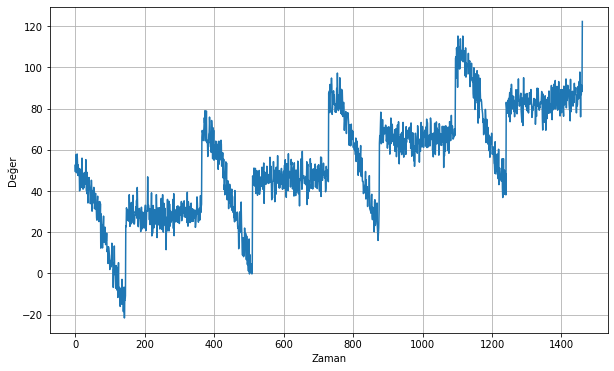

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## 1D Evrişimşli Katmanla Ön İşleme

Bu aşamada bir boyutlu bir evrişim katmanı ile `LSTM` modelimizi iyileştirme aşamasına geçiyoruz. Bunu yapmak için LSTM katmanlarımızdan önce bir adet 1D evrişim katmanı ekliyoruz ve ilk LSTM katmanımızdaki `input_shape` parametresini kaldırıyoruz.

Bu aşamadan sonra aşina olduğumuz gibi ilk olarak ideal `lr` (Learning Rate) değerini bulmaya çalışıyoruz. Bunun için modele bir adet geri arama (callbacks) tanımlayalım ve kerasın LearningRateScheduler işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (lr_schedule) bulunur.

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 34s 76ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 85.9241 - mae: 86.4234
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 82.4703 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 80.2434 - mae: 80.7427
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 72.4508 - mae: 72.9503
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================] - 0s 9

Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(1e-08, 0.0001, 0.0, 30.0)

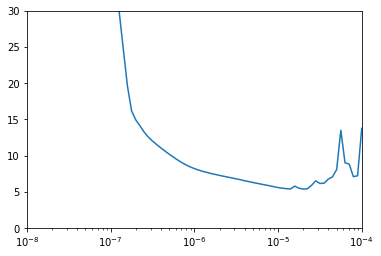

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])


Grafiği incelediğimizde en uygun değerin 1e-5 olacağını kabul edebiliriz. 1e-4 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=50` argümanı 50 yinelemede (epochs) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

`early_stopping` gibi bize yardımcı olabilecek bir diğer callbacks çeşidi `model_checkpoint`'dir. Kayıt notları (`model_checkpoint`) model eğitilirken modelin durumunun iyiye gittiği her yineleme sonrası modeli bir kayıt noktası olarak kaydeder. Eğitim tamamlandığında en iyi modeli seçerek kullanabiliriz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde `callbacks` listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak `epochs` değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 3s 109ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9232 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5628 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 20ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 20ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0114 - val_mae: 16.5063
Epoch 7/500
8/8 [==============================] - 0s 20ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 20ms/step - 


Görüldüğü gibi erken durdurma işlevimiz  71. yinelemeden sonra modelimizin eğitimini durdurdu.

En iyi modelimizi seçmek için `keras.models.load_model` işlevini kullanıyoruz ve en başarılı modelimizi model adlı değişkene atıyoruz.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (`model_forecast`) oluşturmuştuk.

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

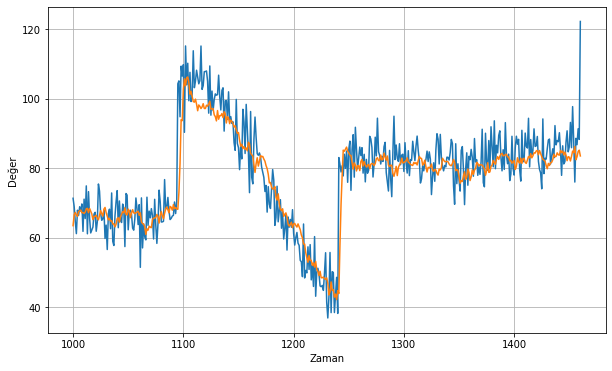

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


Modelimizin performansını ölçelim ve ortalama mutlak hata (mae) değerimizi bulalım.

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.112605

## Tam Evrişimli Sinir Ağı İle Tahmin

Evrişimsel sinir ağları, derin öğrenmenin bir alt dalıdır ve genellikle görsel bilginin analiz edilmesinde kullanılır. Yaygın kullanım alanları resim ve video tanıma, öneri sistemleri resim sınıflandırma, tıbbi görüntü analizi ve doğal dil işleme olarak sıralanabilir.

Yukarıdaki model için yaptığımız aşamaları tekrarlıyoruz. Sadece bu modelimizin tamamıyla evrişimli katmanlardan oluşmasıdır.




Şimdi oluşturduğumuz modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın `LearningRateScheduler` işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur.

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 32ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 36.6836 - mae: 37.1822
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 33.3644 - mae: 33.8628
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 27.9449 - mae: 28.4427
Epoch 11/100
8/8 [==============================] - 0s 9ms


Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(0.0001, 0.1, 0.0, 30.0)

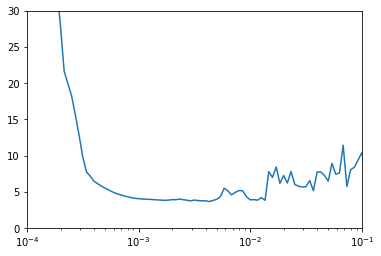

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

Grafiği incelediğimizde en uygun değerin 3e-4 olacağını kabul edebiliriz. 1e-2 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=50` argümanı 50 yinelemede (epochs) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

`early_stopping` gibi bize yardımcı olabilecek bir diğer callbacks çeşidi `model_checkpoint`'dir. Kayıt notları (`model_checkpoint`) model eğitilirken modelin durumunun iyiye gittiği her yineleme sonrası modeli bir kayıt noktası olarak kaydeder. Eğitim tamamlandığında en iyi modeli seçerek kullanabiliriz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde callbacks listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak `epochs` değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 101ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 0s 20ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9777 - val_mae: 68.4777
Epoch 3/500
8/8 [==============================] - 0s 21ms/step - loss: 35.1357 - mae: 35.6344 - val_loss: 60.8664 - val_mae: 61.3664
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 30.8280 - mae: 31.3262 - val_loss: 50.2194 - val_mae: 50.7190
Epoch 5/500
8/8 [==============================] - 0s 21ms/step - loss: 24.9595 - mae: 25.4564 - val_loss: 36.6519 - val_mae: 37.1479
Epoch 6/500
8/8 [==============================] - 0s 20ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5157
Epoch 7/500
8/8 [==============================] - 0s 20ms/step - loss: 18.8909 - mae: 19.3858 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 0s 21ms/st

Görüldüğü gibi erken durdurma işlevimiz  167. yinelemeden sonra modelimizin eğitimini durdurdu.

En iyi modelimizi seçmek için `keras.models.load_model` işlevini kullanıyoruz ve en başarılı modelimizi model adlı değişkene atıyoruz.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (model_forecast) oluşturmuştuk. Bu işlevi kullanarak tahmin yapabiliriz.

In [15]:
model = keras.models.load_model("my_checkpoint.h5")

In [16]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

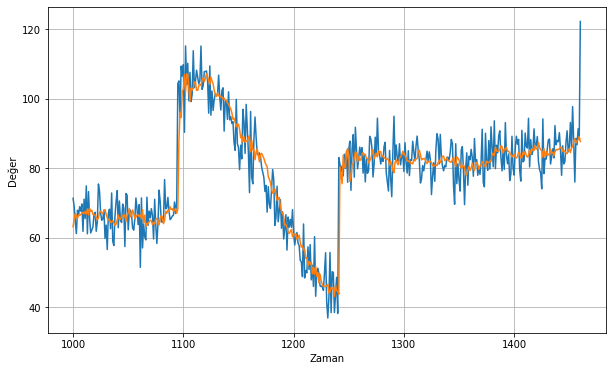

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

Modelimizin performansını ölçelim ve ortalama mutlak hata (`mae`) değerimizi bulalım.

In [18]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.533067

Şimdiye kadar birçok model oluşturduk ve her modelde farklı bir ortalama mutlak hata (mae) değeri elde ettik. En az değeri CNN ile şu an oluşturduğumuz model ile elde etmiş olduk. `accuracy` metriğine göre en başarılı modelimiz şuanki modelimizdir.